### 機器學習百日馬拉松期中練習測驗

- 本賽題提供用戶在2016年1月1日至2016年5月31日之間真實線下消費行為，預測用戶在2016年6月領取優惠券後15天以內的使用情況。 
- [練習競賽網頁](https://www.kaggle.com/t/2eaf9a8ed13847cd9c26f05b2abfe966)
- [baseline kernel參考](https://www.kaggle.com/ml100marathon/baseline-example)


In [11]:
import numpy as np
import pandas as pd
import dateutil.parser as date_parser
import warnings

warnings.filterwarnings('ignore')

In [3]:
# 檢視資料欄位描述
column_desc_df = pd.read_csv('data/midterm/column_description.csv', encoding = 'big5')
for i in column_desc_df.index:
    print(column_desc_df.ix[i][0], column_desc_df.ix[i][1])

User_id 用戶 ID
Merchant_id 商家 ID
Coupon_id 優惠券 ID (null 代表無優惠券消費)
Discount_rate 優惠券折價：[0,1] 代表折扣率；x:y 代表滿 x 減 y 元
Distance 用戶經常活動地點離商家最近距離 (x * 500 公尺), 0 表示低於 500 公尺, 10 表示大於 5 公里。
Date_received 優惠券取得時間
Date 購買商品時間 (如果 Date is null & Coupon_id is not null, 則該紀錄為有優惠券但未使用; 若為 Date is not null & Coupon_id is null, 則為普通消費日期; 若 Date is not null & Coupon_id is not null, 則表示優惠券消費日期)


In [4]:
# 檢視訓練資料
train_df = pd.read_csv('data/midterm/train_offline.csv', encoding = 'big5')
print(train_df.dtypes)
train_df.sample(n = 10)

User_id            int64
Merchant_id        int64
Coupon_id        float64
Discount_rate     object
Distance         float64
Date_received    float64
Date             float64
dtype: object


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
828614,1390326,3381,1807.0,300:30,10.0,20160125.0,NaN
819754,2920918,6043,1987.0,30:5,0.0,20160423.0,NaN
124921,962214,1569,5054.0,200:30,10.0,20160404.0,NaN
998998,3960665,3381,NaN,NaN,2.0,NaN,20160101.0
456523,1581064,3381,1807.0,300:30,2.0,20160130.0,NaN
92958,743826,5965,9404.0,150:20,4.0,20160324.0,NaN
35277,4521840,1379,1579.0,30:5,1.0,20160323.0,NaN
1040315,6907998,3381,1807.0,300:30,1.0,20160124.0,NaN
219972,2847555,1520,8140.0,0.95,NaN,20160110.0,20160110.0
1031459,2745857,3381,11951.0,200:20,10.0,20160129.0,NaN


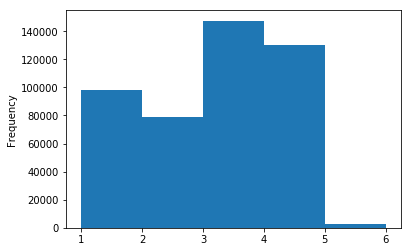

In [6]:
# 1到5月各月份的消費次數 (月份0者，代表無消費)
train_df['shopping_month'] = train_df[np.isnan(train_df['Date']) == False]['Date'].apply(lambda d : int(str(int(d))[4:6]))
train_df['shopping_month'].fillna(0, inplace = True)
train_df['shopping_month'] = train_df['shopping_month'].astype(int)
train_df[train_df['shopping_month'] > 0]['shopping_month'].plot.hist(bins=5)


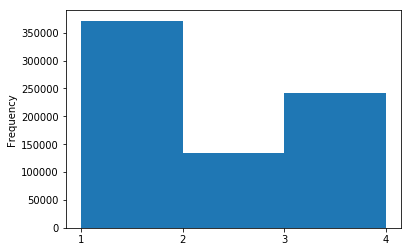

In [7]:
# 優惠券取得月份 (月份0者，代表無優惠券取得日期)
train_df['coupon_month'] = train_df[np.isnan(train_df['Date_received']) == False]['Date_received'].apply(lambda d : int(str(int(d))[4:6]))
train_df['coupon_month'].fillna(0, inplace = True)
train_df['coupon_month'] = train_df['coupon_month'].astype('int')

train_df[train_df['coupon_month'] > 0]['coupon_month'].plot.hist(bins=3, xticks = [1,2,3,4])

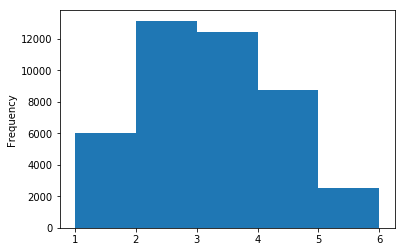

In [8]:
# 各月份使用優惠券消費的次數 (月份0者，代表無使用優惠券消費)
train_df['coupon_shoping_month'] = train_df[(np.isnan(train_df['Date']) == False) & (np.isnan(train_df['Coupon_id']) == False)]['Date'].apply(lambda d : int(str(int(d))[4:6]))
train_df['coupon_shoping_month'].fillna(0, inplace = True)
train_df['coupon_shoping_month'] = train_df['coupon_shoping_month'].astype('int')
train_df[train_df['coupon_shoping_month'] >0]['coupon_shoping_month'].plot.hist(bins=5)

In [27]:
# 優惠券取得日期屬於星期幾(1 Monday - 7 Sunday)

# 用pd.to_datetime, 在macbook上要跑2分鐘
# train_df['Date_received_day_of_week'] = train_df[~np.isnan(train_df['Date_received'])]['Date_received'].apply(lambda d : pd.to_datetime(str(int(d)), format="%Y%m%d").weekday() + 1)
# 用dateutil.parser快多了！ 在macbook上不到5秒
train_df['Date_received_day_of_week'] = train_df[~np.isnan(train_df['Date_received'])]['Date_received'].apply(lambda d : date_parser.isoparse(str(int(d))).date().weekday() + 1)
train_df['Date_received_day_of_week'].fillna(0, inplace = True)
train_df['Date_received_day_of_week'] = train_df['Date_received_day_of_week'].astype('int')

array([1, 2, 3, 4, 5, 6, 7])

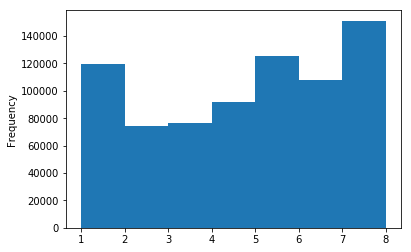

In [29]:
train_df['Date_received_day_of_week'] = train_df['Date_received_day_of_week'].astype('int')
train_df[train_df['Date_received_day_of_week'] >0]['Date_received_day_of_week'].plot.hist(bins=range(1, 9))
np.unique(train_df[train_df['Date_received_day_of_week'] >0]['Date_received_day_of_week'])

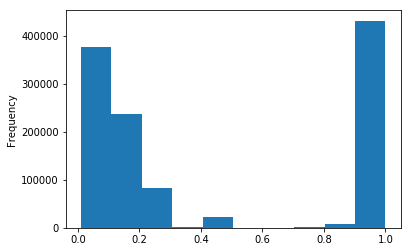

In [30]:
# 折扣率，原Discount_rate可能是小數(0.9)或比例(100:10 滿100減10,其實也等於九折)
def cnvt_discount_rate(rate_obj):
    rate_str = str(rate_obj)
    if rate_str == 'nan':
        return 1
    elif ':' in rate_str:
        _s = rate_str.split(':')
        return int(_s[1])/int(_s[0])
    else:
        return float(rate_str)

train_df['cnvt_discount_rate'] = train_df['Discount_rate'].apply(cnvt_discount_rate)
train_df['cnvt_discount_rate'].plot.hist()

In [52]:
# 有消費 : 未消費 : 總筆數
print(train_df[~np.isnan(train_df['Date'])].shape[0], train_df[np.isnan(train_df['Date'])].shape[0], train_df.shape[0])

# 有用優惠券 : 未使用優惠券 : 有消費筆數 : 總筆數
print(train_df[~np.isnan(train_df['Coupon_id'])].shape[0], 
      train_df[np.isnan(train_df['Coupon_id'])].shape[0], 
      train_df[~np.isnan(train_df['Date'])].shape[0], 
      train_df.shape[0])


456709 704033 1160742
746969 413773 456709 1160742


In [88]:
# 產生label
# Date 購買商品時間
#   Date is null & Coupon_id is not null, 則該紀錄為有優惠券但未使用; label=0
#   Date is null & Coupon_id is null, 則該紀錄為沒有優惠券也沒有使用;  label=-1
#   Date is not null & Coupon_id is null, 則為普通消費日期;      label=-1
#   Date is not null & Coupon_id is not null, 則表示優惠券消費日期
#        Date - Date_received <= 15 , label=1
#                             else  , label=0
 
# 我們要學習的是：拿到優惠券的人，會不會在15天內使用，所以還要考慮Date與Date_received的差距
# 在所有資料中，只保留有拿優惠券者進行學習 （捨棄label = -1者）

def compute_date_diff(date: str, date_received: str):
    return (date_parser.isoparse(date) - date_parser.isoparse(date_received)).days

def compute_label(row):
    if (np.isnan(row['Date'])) & (~np.isnan(row['Coupon_id'])):
        return 0
    elif (~np.isnan(row['Date'])) & (~np.isnan(row['Coupon_id'])):
        if compute_date_diff(str(int(row['Date'])), str(int(row['Date_received']))) <= 15:
            return 1
        else:
            return 0
    else:
        return -1
                                     
train_df['label'] = train_df.apply(compute_label, axis=1)
train_df['label'].describe()

count    1.160742e+06
mean    -3.251963e-01
std      5.310339e-01
min     -1.000000e+00
25%     -1.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: label, dtype: float64

In [86]:
from datetime import date
d1 = date(2019, 6, 1)
d2 = date(2019, 6, 2)
print((d2 -d1).days)

1


In [130]:
# 檢視測試資料
test_df = pd.read_csv('data/midterm/test_offline.csv')
test_df

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received
0,1439408,4663,11002.0,150:20,1.0,20160528.0
1,1439408,2632,8591.0,20:1,0.0,20160613.0
2,1439408,2632,NaN,NaN,0.0,NaN
3,1439408,2632,8591.0,20:1,0.0,20160516.0
4,2029232,450,1532.0,30:5,0.0,20160530.0
5,2029232,6459,12737.0,20:1,0.0,20160519.0
6,2029232,6459,NaN,NaN,0.0,NaN
7,2029232,6459,NaN,NaN,0.0,NaN
8,2747744,6901,1097.0,50:10,NaN,20160606.0
9,196342,1579,NaN,NaN,1.0,NaN
